# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [2]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [4]:
user_params = p21c.UserParams(
    BOX_LEN=301,  # Box length
    DIM=2*301,      # Number of Voxels for hight resolution 
    HII_DIM=301  # Number of Voxels for low resolution 
)

## Creating initial conditions box

In [5]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Gaussian function

In [6]:
def Gaussian(x):  # μ=0, σ=1/sqrt(2), π=1
    Gaussian = np.exp(-(x**2))
    return Gaussian

## Measure the distance of each voxel to the center

In [7]:
def distance_from_coordinate(box_length):
    
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [8]:
def random_voxel(box_length):
    
    np.random.seed()  # set seed to a randome number
#     np.random.seed(4) ; np.random.rand(10)

    coordinate = np.random.randint(0, box_length, size=3)

    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [9]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = coordinate_array[0]-radius  # x-domian
    x_ind2 = coordinate_array[0]+radius+1  # ending index is not inclusive
    y_ind1 = coordinate_array[1]-radius  # y-domain
    y_ind2 = coordinate_array[1]+radius+1
    z_ind1 = coordinate_array[2]-radius  # z-domain
    z_ind2 = coordinate_array[2]+radius+1

    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+len(box)):len(box), 0:x_ind2]
    elif x_ind2 > len(box):
        x_inds = np.r_[x_ind1:len(box), 0:(x_ind2-len(box))]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+len(box)):len(box), 0:y_ind2]
    elif y_ind2 > len(box):
        y_inds = np.r_[y_ind1:len(box), 0:(y_ind2-len(box))]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+len(box)):len(box), 0:z_ind2]
    elif z_ind2 > len(box):
        z_inds = np.r_[z_ind1:len(box), 0:(z_ind2-len(box))]
    else:
        z_inds = np.r_[z_ind1:z_ind2]

    indices = np.ix_(x_inds, y_inds, z_inds)
    
    output_box = box[indices]
    
    return output_box

## Gausssian Sphere Averaging

In [10]:
def gaussian_sphere_average(distance_box, radius, input_box, shell_num, sigma_factor):
    
    mean = []

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])
    weight = Gaussian(x=shell_center*sigma_factor)

    for ii in range(shell_num):
        condition = np.logical_and(distance_box <= shell_radius_edges[ii+1]*radius, distance_box > shell_radius_edges[ii]*radius)
        inside_shell_mean = np.mean(input_box[condition])
        mean = np.append(mean, inside_shell_mean)
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Top Hat Sphere Averaging

In [11]:
def top_hat_sphere_average(distance_box, radius, input_box):
    
    condition = distance_box <= radius
    mean = np.mean(input_box[condition])
    
    return mean

## Top Hat Cube Averaging

In [12]:
def top_hat_cube_average(input_box):
    
    mean = np.mean(input_box)
    
    return mean

## Sphere Blurring Function

In [13]:
def Average_Neutral_Fraction_Distribution(box, radius, iteration, shell_num=6, sigma_factor=3*1.4370396997748922, blur_shape=None):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    mean_data = []  # empty list for data collection
    
    if blur_shape == 'Gaussian_sphere':
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
        
    elif blur_shape == 'top_hat_sphere':
        radius = round(radius/1.4370396997748922/3)  # ratio numerically calculated.
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_sphere_average(dist_frm_coord_box, radius, cube_region_box)
            mean_data = np.append(mean_data, mean)
            
    elif blur_shape == 'top_hat_cube':
        radius = round((radius*((4*np.pi/3)**(1/3))/1.4370396997748922/3-1)/2)  # ratio determiend by equating the volumes of cube & sphere
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = top_hat_cube_average(cube_region_box)
            mean_data = np.append(mean_data, mean)
    else:
        print('Blurring shape assumed to be a Gaussian sphere with 4 shells weighted by equally spaced values from 0 sigma to 4 sigma.')
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        for i in range(iteration):
            rand_coord = random_voxel(len(box))
            cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
            mean = gaussian_sphere_average(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
            mean_data = np.append(mean_data, mean)
            
    return mean_data

## Histogram Function

In [14]:
def histogram(fs, title, figure_shape, x_start=0, x_stop=1, bin_num=100, color='white', figure_size=(18,7), font_size=15, horizontal_gap=0.05, vertical_gap=0.05):  # a: x start, b: x stop
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    if len(fs) > 10:  # assuming that iterations will be at least 10, and not plotting more than 9 plots at once, quick fix, need more robust condtion.
        fig, ax = plt.subplots(figsize=figure_size)
        ax.plot(bin_centers, np.histogram(fs, bins=bin_edges)[0])
        ax.set_title(title, color=color, fontsize=font_size)
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size)  # figure color
        ax.set_yscale('log')
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
    else:
        fig, axes = plt.subplots(figure_shape[0], figure_shape[1], figsize=figure_size, sharex=True, sharey=True, gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap})
        for i, f in enumerate(fs):
            axes.flatten()[i].plot(bin_centers, np.histogram(f, bins=bin_edges)[0])
            axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
            axes.flatten()[i].tick_params(color=color, labelcolor=color, labelsize=font_size)  # figure color
            axes.flatten()[i].set_yscale('log')
            for spine in axes.flatten()[i].spines.values():
                spine.set_edgecolor(color)

## Creating Ionize box

In [15]:
ionized = p21c.ionize_box(redshift=6.5, init_boxes=init_cond).xH_box

## Creating Noise Box

In [16]:
np.random.seed()
# np.random.seed(5) ; np.random.rand(10)
noise_box = np.random.rand(301, 301, 301)

## Blurring the box

In [17]:
gaussian24 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=24, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [18]:
gaussian22 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=22, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [19]:
gaussian20 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=20, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [20]:
gaussian18 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=18, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [21]:
gaussian16 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=16, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [22]:
gaussian14 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=14, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [23]:
gaussian12 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=12, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [24]:
gaussian10 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=10, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

In [25]:
gaussian8 = Average_Neutral_Fraction_Distribution(
    box=ionized, 
    radius=8, 
    iteration=10**5, 
    blur_shape='Gaussian_sphere'
)

## Creating Histogram

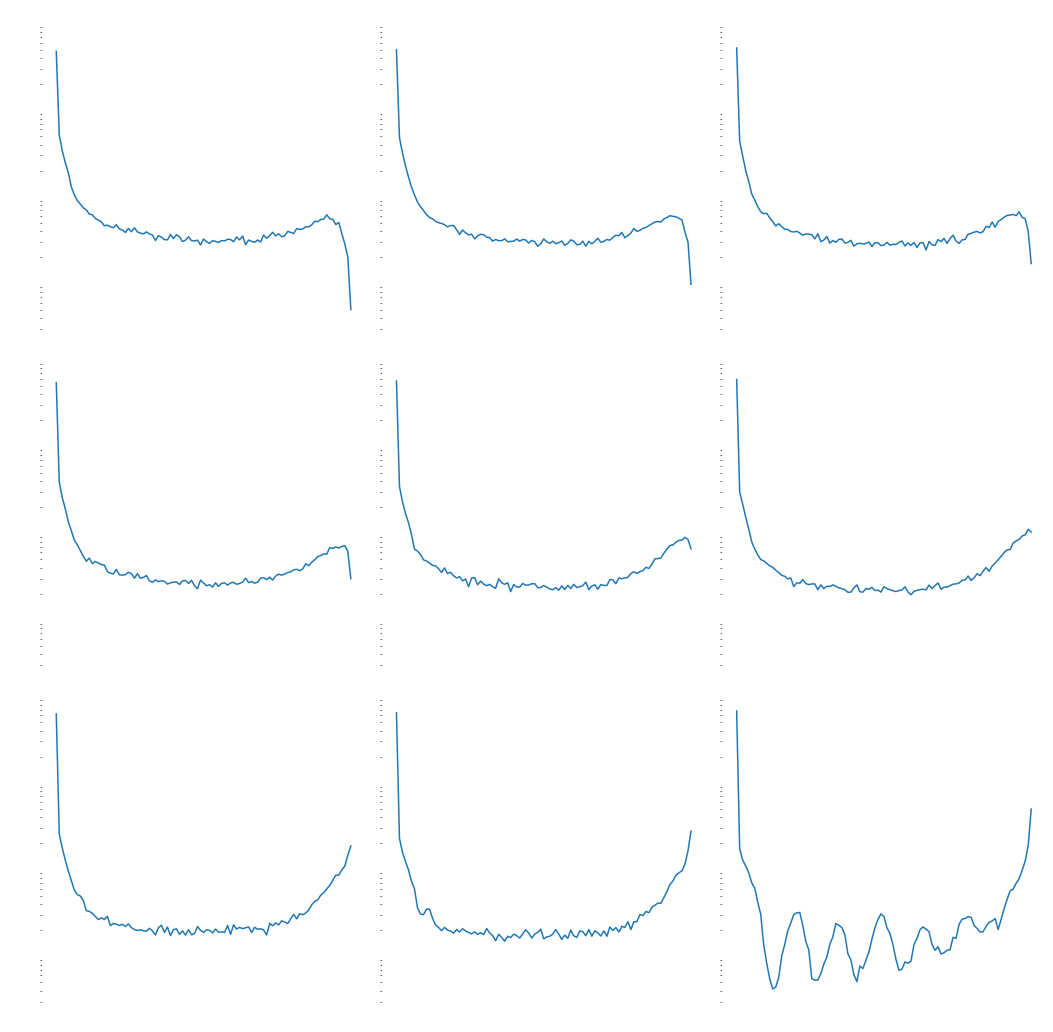

In [26]:
histogram([gaussian24, gaussian22, gaussian20, gaussian18, gaussian16, gaussian14, gaussian12, gaussian10, gaussian8], title=['gaussian24', 'gaussian22', 'gaussian20', 'gaussian18', 'gaussian16', 'guassian14', 'gaussian12', 'gaussian10', 'gaussian8'], figure_shape=(3, 3), figure_size=(18, 18), vertical_gap=0.1)

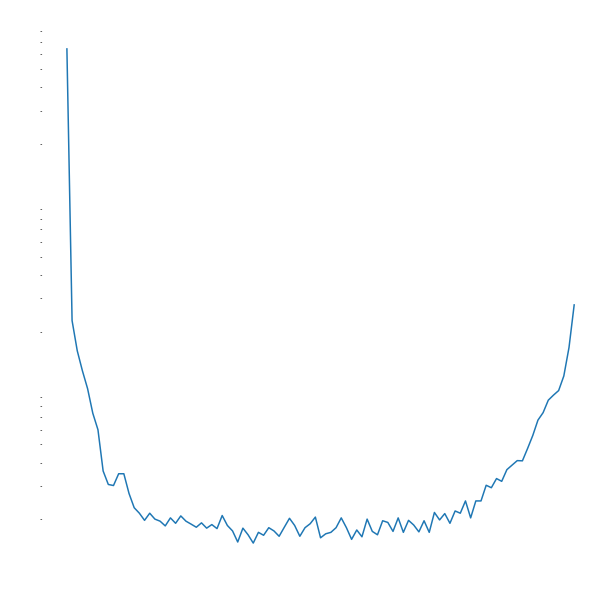

In [27]:
histogram(fs=gaussian10, title='gaussian10', figure_shape=(1, 1), figure_size=(10, 10))

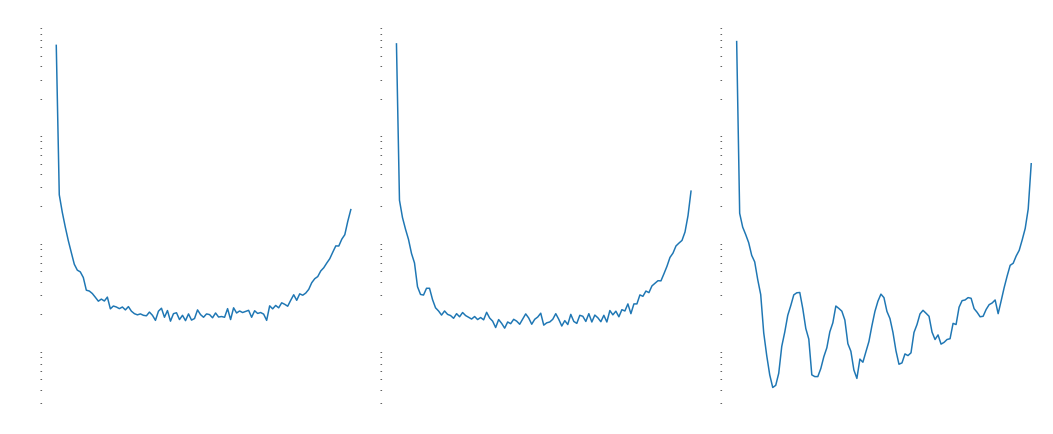

In [29]:
histogram([gaussian12, gaussian10, gaussian8], title=['guassian12', 'gaussian10', 'gaussian8'], figure_shape=(1, 3))